# Shift-tilted HG(0,0) - ALEX

In [4]:
import PauLisa as pl, numpy as np, matplotlib.pyplot as plt, cmath as cm, mpmath as mp
from scipy.special import erfc,erf
from math import exp
from scipy import integrate
from math import inf
from pprint import pprint


In [5]:
#constants
pi = np.pi

#Redefining and naming initial parameters
high_res_plane = pl.Plane(-6e-3,7e-3,1000,-1e-3,1e-3,3) #just used to calculate peak, higher precision
plane = pl.Plane(-5e-3,5e-3,1000,-5e-3,5e-3,1000)
params = pl.Params(wavelength=1.064e-06, w0=1e-3, z0=0)

lam = params.wavelength #wavelength
w0 = 1e-3 #spot size
k = params.k #wavenumber
z0 = params.z0 #waist location
Zr = params.Zr #rayleigh range
a=100e-6

## PLOT SCALES AND LABELS
micro = 10**(6)
nano = 10**(9)
cycle = 1/(2*pi)
rad = 1
xlab = 'u'
ylab = 'rad'

##SET SCALES
alpha_scale = micro
phase_scale = rad

if(alpha_scale==nano):
    xlab = 'n'
if(phase_scale==cycle):
    ylab = 'cycles'

Sorry to get this to you so late, been a busy day. This is for the phases of the two beams over a certain rectangular section, taking y from negative infinity to infinity but x bounds not set with x_t being the upper bound and x_b being the lower bound (so for the right hand side you would take x_t to be infinite and x_b to be the gap to the right side of the center). For the DWS you take the phase of the right side (again x_t set to infinity, x_b to the right hand gap) minus the phase of the left side (setting x_t to be the left hand side portion, or if symmetric on both sides this would just be -x_b from the other one, and x_b for this one would be negative infinity). 

In general the phase has two parts, a part that is common for both and will subtract out for the DWS, this will be in the expression phase_common, so you should add it in only for the GW or total path length phase. For the GW signal this will be added to the phase of the error function portion, which contains x_b and x_t in it, and which I haven't calculated the phase of (so you should just use a phase extraction function on this portion, which I will label error_portion). The phase_common section does not have these in it because it is common to both. This means we write GWSignal = phase_common + (1/2)*(Phase(error_portion,Right) + Phase(error_portion,Left)).

The DWS signal will just be the phase of the error portions subtracted since the common portion will subtract out, so that 
DWS = (1/2)*(Phase(error_portion,Right) - Phase(error_portion,Left))

if not obvious, Phase(error_portion,Right/Left) is the phase of error_portion when you have set the error_portion x_t and x_b parameters to correspond to the right and left sides of the photodiode respectively.

You will find phase_common and error_portion attached. I have also included definitions for the variables sigma and gamma, in the file definitions_paul. In these the 1 subscript refers to parameters for the local oscillator while the 2 subscript is for parameters for the measurement gaussian beam, so w_1 lowercase is the waist of the local oscillator, d_1 is the distance of the photodiode from the waist of the local oscillator, z_{r1} is the rayleigh range for the local oscillator, k_1 is the wavenumber of the local oscillator, capitol W_1 is the beam width of the local oscillator at the photodiode, and the same goes for the 2 subscript for the measurement beam.

Also x_0 is the lateral offset of the measurement beam that we then tilt by angle theta_0. And note that the phase_common also contains the phase we expect for the gravitational wave signal, Delta omega t - Delta k z, while graphing you should ignore this portion because we want to look at the addition to this.


Phase common:
\begin{align*}
		\Phi(exp) =&
            \Delta \omega t - \Delta kz + k_2 x_0 sin \theta_0 + \Delta\Psi - \frac{d_2 x_0^2}{z_{r2}W_2^2}
            \\&+
            \frac
            {
                x_0 W_1^2 (W_1^2 + W_2^2)
                ( \frac{2d_2 x_0}{z_{r2} W_2^2}-k_2 \sin \theta_0)
                +
                W_1^2 W_2^2 (\frac{d_2W_1^2}{z_{r2}}-\frac{d_1 W_2^2}{z_{r1}})
                (\frac{x_0^2}{W_2^4}-(\frac{d_2 x_0}{z_{r2} W_2^2}-\frac{k_2 \sin\theta_0}{2})^2 )
            }
            {
                (W_1^2+W_2^2) 
                +
                (\frac{d_2 W_1^2}{z_{r2} }- \frac{d_1 W_2^2}{z_{r1}})
            }
\end{align*}

Definitions:

$d_1 = z-z_0$

\begin{equation}
    \sigma = \frac{1}{w_1^2(1+i\frac{d_1}{z_{r1}})}
        + \frac{1}{w_2^2(1-i\frac{d_2}{z_{r2}})}
\end{equation}


\begin{equation}
    \gamma = \frac{2 x_0}{w_2^2(1-i \frac{d_2}{z_{r2}})}
        -  ik_2 \sin \theta_0
\end{equation}

Error Portion:
$
    [
    erf(\sqrt{\sigma}(x_t-\frac{\gamma}{2 \sigma}))
    -erf(\sqrt{\sigma}(x_b-\frac{\gamma}{2 \sigma}))
    ]
$

DWS signal:
$ \frac{1}{2}
[
arg(
    erf(\sqrt{\sigma}(x_t-\frac{\gamma}{2 \sigma}))
    -erf(\sqrt{\sigma}(x_b-\frac{\gamma}{2 \sigma}))
    )
-
arg(
    erf(\sqrt{\sigma}(x_t-\frac{\gamma}{2 \sigma}))
    -erf(\sqrt{\sigma}(x_b-\frac{\gamma}{2 \sigma}))
    )
]
$
,where the first arg is right portion and second is left

In [22]:
#phase common
def common(b1,b2,a,alpha):
    common_result=(
        b2.k*a*np.sin(alpha)
        -
        (b2.d*a**2)/(b2.zr*b2.W**2)
        +
        np.imag(gamma(b1,b2,a,alpha)**2/(4*sigma(b1,b2)))
    )
    return(common_result)

#GWS function
def gws(b1,b2,a,alpha,pd_r,pd_l):
    gws_result= ( common(b1,b2,a,alpha)+0.5
                 *(np.angle(error(b1,b2,a,alpha,pd_r))
                   +np.angle(error(b1,b2,a,alpha,pd_l)) ) 
    )
    return(gws_result)

#DWS function = 1/2 (error_right-error_left)    
def phase_dws(b1,b2,a,alpha,pd_r,pd_l): 
    return( 0.5*(np.angle(error(b1,b2,a,alpha,pd_r))-np.angle(error(b1,b2,a,alpha,pd_l)) ) )

######Defined functions



#error portions
def error(b1,b2,a,alpha,pd):
    
    error_t = ( erf(np.sqrt(sigma(b1,b2))*(pd.xt - ( gamma(b1,b2,a,alpha)/(2*sigma(b1,b2)) ))) )
   
    error_b = ( erf(np.sqrt(sigma(b1,b2))*(pd.xb - (gamma(b1,b2,a,alpha)/(2*sigma(b1,b2)) ))) )
    
    error_result = error_t-error_b
    
    return(error_result)

#sigma, where a = lateral offset = x0
def gamma(b1,b2,a,alpha):
    
    gamma_result=(
        2*a / ( (b2.w**2) *(1- (1j)* b2.d/b2.zr) )
        -
        (1j)*k*np.sin(alpha)
    )
    
    return(gamma_result)

#gamma function
def sigma(b1,b2):
    
    sigma_result=(
        1 / (b1.w**2 *(1+ (1j)* b1.d/b1.zr) )
        +
        1 / (b2.w**2 *(1- (1j)* b2.d/b2.zr) )
    ) 
    
    return(sigma_result)

In [23]:
#beam class to pass local and meas params
class Beam:
    def __init__(self,w,zr,d,W,k):
        self.w=w #waist (SIZE?)
        self.zr=zr #rayleigh range
        self.d=d #distance (optical z)
        self.W=W #beam width at PD
        self.k=k #wavenumber

#photodetector class with upper/lower bounds
class PD:
    def __init__(self,xb,xt):
        self.xb=xb #lower bound
        self.xt=xt #upper bound

     

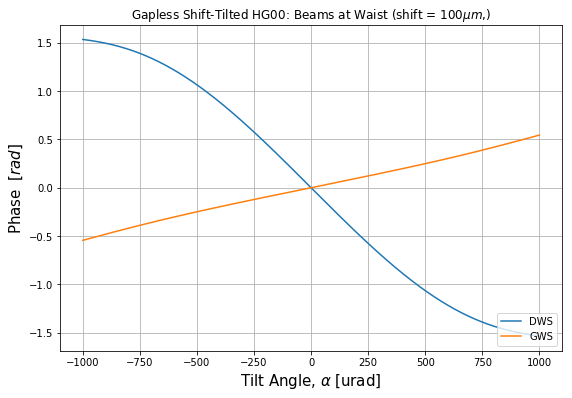

In [27]:
plt.figure(figsize=(9,6))

######PLOTS
alpha = np.linspace(-1000e-6,1000e-6,1000) # tilt angle

gap_factor=0.0
pd_r = PD(xb=plane.xmax*gap_factor,xt=2e-3)
pd_l = PD(xb=-2e-3,xt=plane.xmin*gap_factor)


##
a = 100e-6 #lateral shift 
b1 = Beam(w=1e-3, zr=params.Zr, d=0, W=1e-3, k =params.k) #local beam
b2 = Beam(w=1e-3, zr=params.Zr, d=0, W=1e-3, k =params.k) #meas beam
plt.plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l)*phase_scale, label='DWS' )
plt.plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l)*phase_scale, label='GWS' )
plt.legend(loc='lower right')

#####LABELS
#plt.legend(title="Parameters",loc="upper right", fontsize=14)

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + xlab +'rad]', fontsize=15) 
plt.ylabel(r'Phase $\;[' + ylab + ']$', fontsize=15) 

plt.title(r'Gapless Shift-Tilted HG00: Beams at Waist (shift = 100$\mu m$,)') 

plt.grid()
plt.savefig("AW-tilt-shift-waist.pdf")

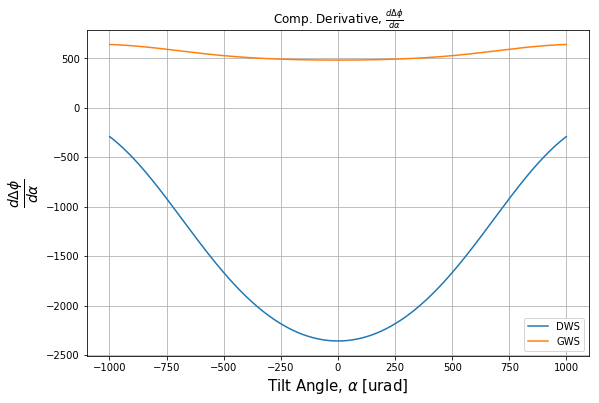

In [25]:
#function
comp_phase_diff_deriv = np.diff(phase_dws(b1,b2,a,alpha,pd_r,pd_l)) / np.diff(alpha)
comp_gws_deriv = np.diff(gws(b1,b2,a,alpha,pd_r,pd_l)) / np.diff(alpha)
alpha2 = (alpha[:-1] + alpha[1:]) / 2

#plot (a*1e6 for microrad, diff/2pi for cycles)
plt.figure(figsize=(9,6))
plt.plot(alpha2*alpha_scale, comp_phase_diff_deriv*phase_scale, label='DWS') 
plt.plot(alpha2*alpha_scale, comp_gws_deriv*phase_scale, label='GWS') 
plt.legend(loc='lower right')

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + xlab +'rad]',fontsize=15) 
plt.ylabel(r'$ \frac{d \Delta \phi}{d \alpha}$', fontsize=20) 
plt.title(r'Comp. Derivative, $\frac{d \Delta \phi}{d \alpha}$') 
plt.grid()
plt.savefig("AW-tilt-shift-waist-DER.pdf")

### Changing gap and shift at the waist

Local Beam{'w': 0.001, 'zr': 2.952624674426497, 'd': 0, 'W': 0.001, 'k': 5905249.348852994}
Measured beam{'w': 0.001, 'zr': 2.952624674426497, 'd': 0, 'W': 0.001, 'k': 5905249.348852994}


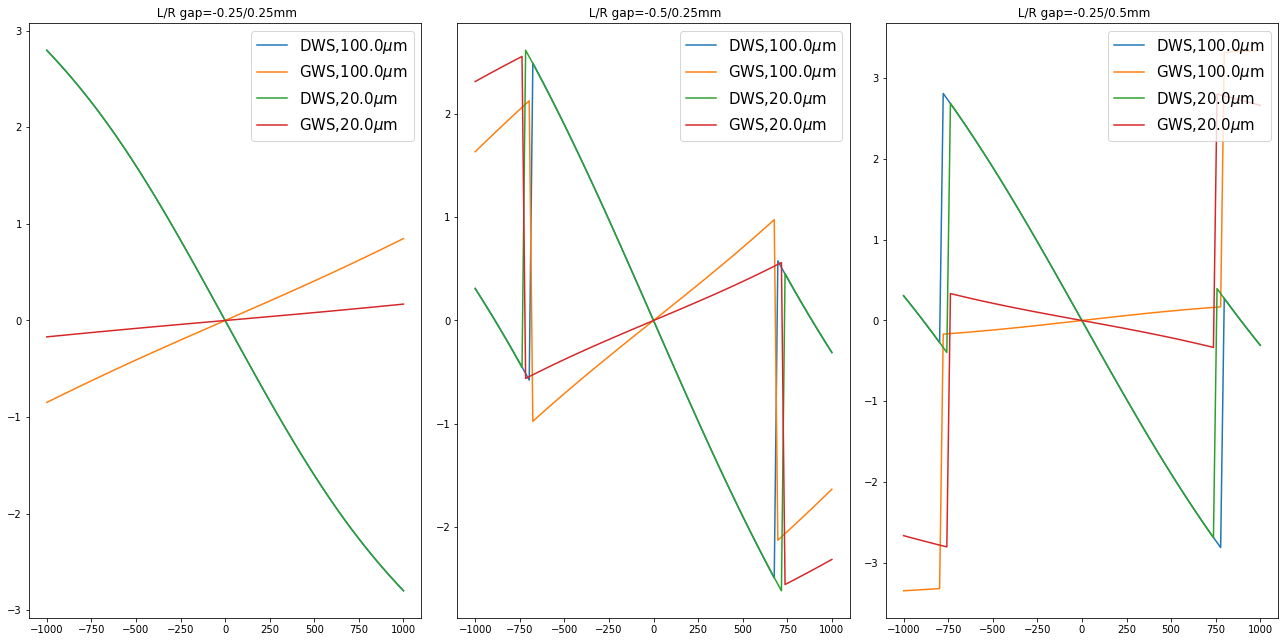

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))


######PLOTS
alpha = np.linspace(-1000e-6,1000e-6,100) # tilt angle
b1 = Beam(w=1e-3, zr=params.Zr, d=0, W=1e-3, k =params.k) #local beam
b2 = Beam(w=1e-3, zr=params.Zr, d=0, W=1e-3, k =params.k) #meas beam

##
print('Local Beam' + str(vars(b1)) )
print('Measured beam' + str(vars(b1)) )

#
gap_factor_l=0.05
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 100e-6 #lateral shift 
axes[0].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[0].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[0].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

##
gap_factor_l=0.1
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 100e-6 #lateral shift 
axes[1].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[1].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[1].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')


##
gap_factor_l=0.05
gap_factor_r=0.1
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 100e-6 #lateral shift 
axes[2].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[2].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[2].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

#
gap_factor_l=0.05
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 20e-6 #lateral shift 

axes[0].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[0].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[0].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

##
gap_factor_l=0.1
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)

axes[1].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[1].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[1].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')


##
gap_factor_l=0.05
gap_factor_r=0.1
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)

axes[2].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[2].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[2].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

axes[0].legend(loc="upper right", fontsize='15')
axes[1].legend(loc="upper right", fontsize='15')
axes[2].legend(loc="upper right", fontsize='15')

fig.savefig('ALEX-HG00-'+str(b1.d) +'-'+str(b2.d)+ '.pdf')
fig.tight_layout()

### Changing gap symmetries at d1=1mm, d2=0mm

Local Beam{'w': 0.001, 'zr': 2.952624674426497, 'd': 0.001, 'W': 0.001, 'k': 5905249.348852994}
Measured beam{'w': 0.001, 'zr': 2.952624674426497, 'd': 0.001, 'W': 0.001, 'k': 5905249.348852994}


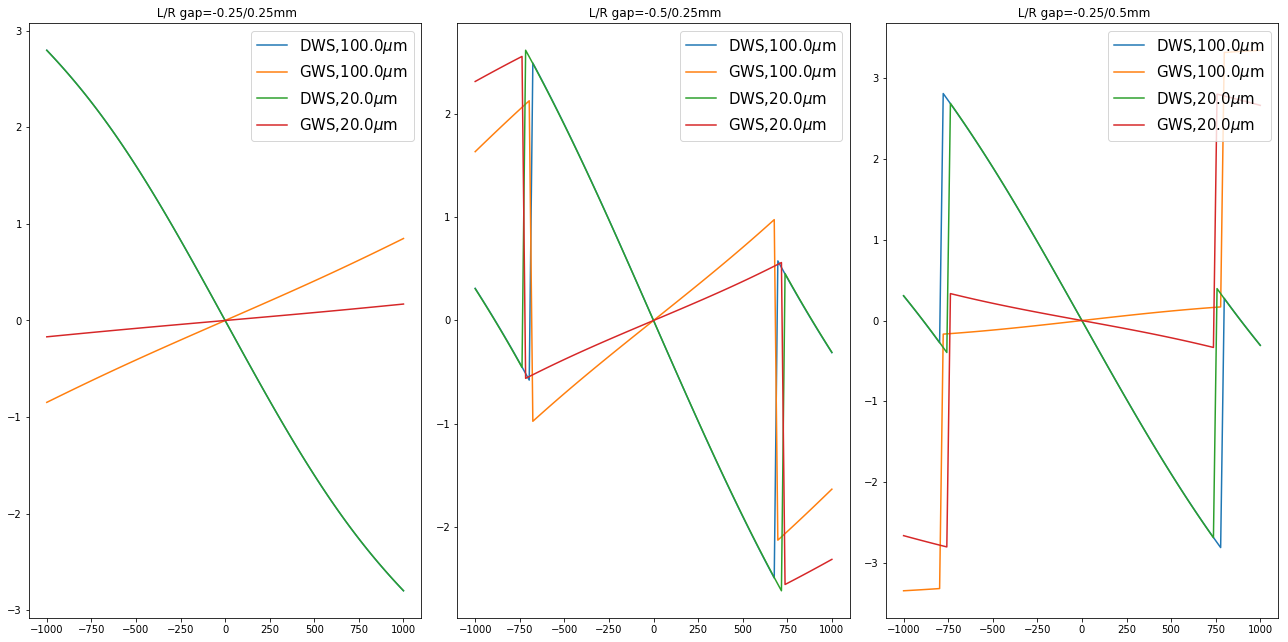

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))


######PLOTS
alpha = np.linspace(-1000e-6,1000e-6,100) # tilt angle
b1 = Beam(w=1e-3, zr=params.Zr, d=1e-3, W=1e-3, k =params.k) #local beam
b2 = Beam(w=1e-3, zr=params.Zr, d=0, W=1e-3, k =params.k) #meas beam

##
print('Local Beam' + str(vars(b1)) )
print('Measured beam' + str(vars(b1)) )

#
gap_factor_l=0.05
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 100e-6 #lateral shift 
axes[0].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[0].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[0].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

##
gap_factor_l=0.1
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 100e-6 #lateral shift 
axes[1].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[1].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[1].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')


##
gap_factor_l=0.05
gap_factor_r=0.1
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 100e-6 #lateral shift 
axes[2].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[2].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[2].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

#
gap_factor_l=0.05
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 20e-6 #lateral shift 

axes[0].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[0].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[0].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

##
gap_factor_l=0.1
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)

axes[1].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[1].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[1].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')


##
gap_factor_l=0.05
gap_factor_r=0.1
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)

axes[2].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[2].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[2].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

axes[0].legend(loc="upper right", fontsize='15')
axes[1].legend(loc="upper right", fontsize='15')
axes[2].legend(loc="upper right", fontsize='15')

fig.savefig('ALEX-HG00-'+str(b1.d) +'-'+str(b2.d)+ '.pdf')
fig.tight_layout()

### Changing gap symmetries at d1=1mm, d2=1mm

Local Beam{'w': 0.001, 'zr': 2.952624674426497, 'd': 0.001, 'W': 0.001, 'k': 5905249.348852994}
Measured beam{'w': 0.001, 'zr': 2.952624674426497, 'd': 0.001, 'W': 0.001, 'k': 5905249.348852994}


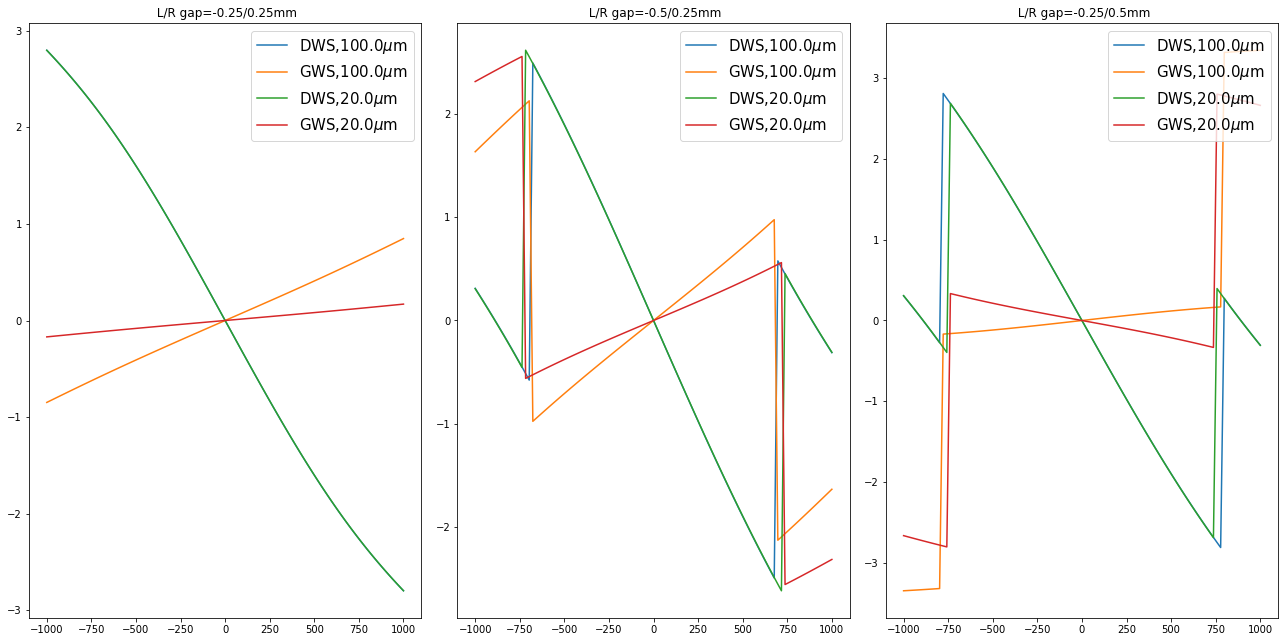

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))


######PLOTS
alpha = np.linspace(-1000e-6,1000e-6,100) # tilt angle
b1 = Beam(w=1e-3, zr=params.Zr, d=1e-3, W=1e-3, k =params.k) #local beam
b2 = Beam(w=1e-3, zr=params.Zr, d=1e-3, W=1e-3, k =params.k) #meas beam

##
print('Local Beam' + str(vars(b1)) )
print('Measured beam' + str(vars(b1)) )

#
gap_factor_l=0.05
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 100e-6 #lateral shift 
axes[0].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[0].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[0].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

##
gap_factor_l=0.1
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 100e-6 #lateral shift 
axes[1].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[1].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[1].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')


##
gap_factor_l=0.05
gap_factor_r=0.1
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 100e-6 #lateral shift 
axes[2].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[2].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[2].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

#
gap_factor_l=0.05
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 20e-6 #lateral shift 

axes[0].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[0].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[0].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

##
gap_factor_l=0.1
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)

axes[1].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[1].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[1].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')


##
gap_factor_l=0.05
gap_factor_r=0.1
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)

axes[2].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[2].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[2].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

axes[0].legend(loc="upper right", fontsize='15')
axes[1].legend(loc="upper right", fontsize='15')
axes[2].legend(loc="upper right", fontsize='15')

fig.savefig('ALEX-HG00-'+str(b1.d) +'-'+str(b2.d)+ '.pdf')
fig.tight_layout()

### Changing gap symmetries at d1=100mm, d2=100mm

Local Beam{'w': 0.001, 'zr': 2.952624674426497, 'd': 0.1, 'W': 0.001, 'k': 5905249.348852994}
Measured beam{'w': 0.001, 'zr': 2.952624674426497, 'd': 0.1, 'W': 0.001, 'k': 5905249.348852994}


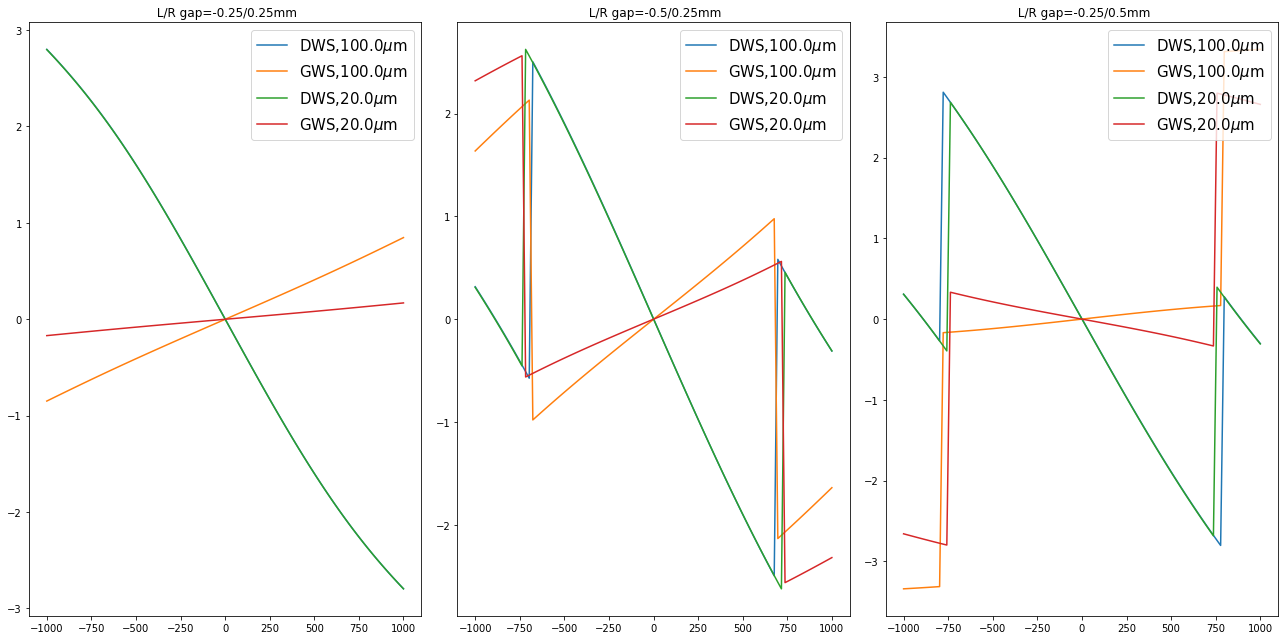

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))


######PLOTS
alpha = np.linspace(-1000e-6,1000e-6,100) # tilt angle
b1 = Beam(w=1e-3, zr=params.Zr, d=100e-3, W=1e-3, k =params.k) #local beam
b2 = Beam(w=1e-3, zr=params.Zr, d=100e-3, W=1e-3, k =params.k) #meas beam

##
print('Local Beam' + str(vars(b1)) )
print('Measured beam' + str(vars(b1)) )

#
gap_factor_l=0.05
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 100e-6 #lateral shift 
axes[0].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[0].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[0].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

##
gap_factor_l=0.1
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 100e-6 #lateral shift 
axes[1].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[1].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[1].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')


##
gap_factor_l=0.05
gap_factor_r=0.1
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 100e-6 #lateral shift 
axes[2].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[2].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[2].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

#
gap_factor_l=0.05
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)
a = 20e-6 #lateral shift 

axes[0].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[0].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[0].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

##
gap_factor_l=0.1
gap_factor_r=0.05
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)

axes[1].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[1].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[1].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')


##
gap_factor_l=0.05
gap_factor_r=0.1
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=2e3)
pd_l = PD(xb=-2e3,xt=plane.xmin*gap_factor_l)

axes[2].plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l),label='DWS,' + str(a*1e6)+'$\mu$m' )
axes[2].plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l),label='GWS,' + str(a*1e6)+'$\mu$m' )
axes[2].set(title=' L/R gap='
               + str(pd_l.xt*1000)
               +'/'
               + str(pd_r.xb*1000)
               +'mm')

axes[0].legend(loc="upper right", fontsize='15')
axes[1].legend(loc="upper right", fontsize='15')
axes[2].legend(loc="upper right", fontsize='15')

fig.tight_layout()
fig.savefig('ALEX-HG00-'+str(b1.d) +'-'+str(b2.d)+ '.pdf')

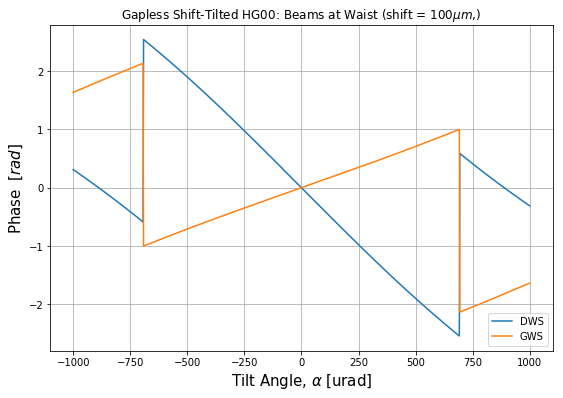

In [18]:
plt.figure(figsize=(9,6))

######PLOTS
alpha = np.linspace(-1000e-6,1000e-6,1000) # tilt angle

gap_factor_r=0.05
gap_factor_l=0.1
pd_r = PD(xb=plane.xmax*gap_factor_r,xt=plane.xmax)
pd_l = PD(xb=-plane.xmax,xt=-plane.xmax*gap_factor_l)


##
a = 100e-6 #lateral shift 
b1 = Beam(w=1e-3, zr=params.Zr, d=0, W=1e-3, k =params.k) #local beam
b2 = Beam(w=1e-3, zr=params.Zr, d=0, W=1e-3, k =params.k) #meas beam
plt.plot(alpha*alpha_scale, phase_dws(b1,b2,a,alpha,pd_r,pd_l)*phase_scale, label='DWS' )
plt.plot(alpha*alpha_scale, gws(b1,b2,a,alpha,pd_r,pd_l)*phase_scale, label='GWS' )
plt.legend(loc='lower right')

#####LABELS
#plt.legend(title="Parameters",loc="upper right", fontsize=14)

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + xlab +'rad]', fontsize=15) 
plt.ylabel(r'Phase $\;[' + ylab + ']$', fontsize=15) 

plt.title(r'Gapless Shift-Tilted HG00: Beams at Waist (shift = 100$\mu m$,)') 

plt.grid()
plt.savefig("AW-tilt-shift-waist-gap.pdf")

In [ ]:
#phase common
def common(b1,b2,a,alpha):
    common_result=(
        b2.k*a*np.sin(alpha)
        -
        (b2.d*a**2)/(b2.zr*b2.W**2)
        +
        (
        (a*b1.W**2)*(b1.W**2+b2.W**2)*( (2*b2.d*a)/(b2.zr*b2.W**2) - b2.k*np.sin(alpha) )
        +
        b1.W**2 * b2.W**2
        * ( (b2.d*b1.W**2)/b2.zr - (b1.d*b2.W**2)/b1.zr )
        * (a**2/b2.W**4 - ( (b2.d*a)/(b2.zr*b2.W**2) - b2.k*np.sin(alpha)/2 )**2 )
        )
        /
        (
        (b1.W**2+b2.W**2)
        +
        (b2.d*b1.W**2/b2.zr - b1.d*b2.W**2/b1.zr)
        )
    )
    return(common_result)

In [26]:
print(a*k/2)

295.2624674426497


In [ ]:
print()